## Final project. Applied Mathematics / Numerical Analysis / P1.4

Using Lagrangian finite elements with Chebyshev nodes, defined on square, of arbitrary order

Find the solution of 

$$
-\Delta \mathbf u + \mathbf u = \mathbf f \text{ in } \Omega, \qquad n \cdot \delta u = 0 \text{ on } \partial \Omega
$$

on the square $\Omega = [0,1]^2$. For the sake of simplicity you can consider just **one finite element** and homogeneous Neumann boundary conditions. 

The above problem can be rewritten in matrix form as

$$
A u = (K+M) u =  b
$$

where $K$ is the stiffness matrix, and $M$ is the mass matrix.

In order to do so, express $u$ as a linear combination of basis functions, multiply from the left with a basis function, and integrate by parts the laplacian to obtain:

$$
K_{ij} := \int_\Omega \nabla v_i \cdot \nabla v_j,\qquad M_{ij} = \int_\Omega v_i v_j, \qquad b_i = \int_\Omega v_i f
$$

In [1]:
%pylab inline
import numpy as np
import sympy as sym
import numpy.polynomial.legendre as leg
from scipy.sparse.linalg import cg
from mpl_toolkits.mplot3d import Axes3D
from numpy.testing import *
from numpy.linalg import cond

Populating the interactive namespace from numpy and matplotlib


### 1 Construct (or use the available functions from numpy/scipy) the chebishev nodes of given order

Once you constructed them, plot them.

In [23]:
order = 5 # You should be able to change this, and everything else should work accordingly

#bounduaries:
a = 0
b = 1

C = zeros((order)) # Call C the chebishev nodes between 0 and 1

C = [ 0.5*(a+b) + 0.5*(b-a)*np.cos((2*k-1)*np.pi/(2*order)) for k in range (1, order + 1) ]

### 2 Construct (or use the available functions from numpy/scipy) the one-dimensional Lagrange basis functions on the Chebishev nodes
Make sure each entry of basis_1d is a callable function, that you can evaluate at a given point. Plot all of the basis functions, using a numpy array `Vs`, storing all basis functions evaluated on evenly spaced points, called `s`

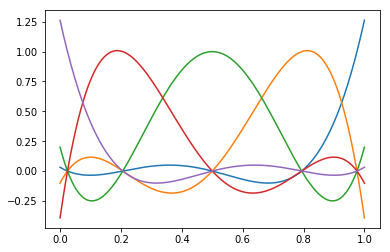

In [25]:
plot_resolution = 257

def lagrange_basis(xi, i):
    def func(x):
        assert i<len(xi) and i>=0,  'Out of range: 0 t< i < len(xi)'
        p = 1
        for j,xj in enumerate(xi):
            if (j!=i):
                p *= (x-xj)/(xi[i]-xj)
        return p
    return func

basis_1d = [] 
for k in range(0,order):
    basis_1d.append(lagrange_basis(C,k))    

Vs = zeros((plot_resolution, order))

s = linspace(0, 1, plot_resolution)
# YOUR CODE HERE to fill Vs
for i in range(0, order):
    Vs[:,i] = basis_1d[i](s)

## Example plot:
_ =  plot(s, Vs)

### 3 Construct three one-dimensional quadrature formulas, to integrate the matrices, the right hand side, and the error

In general the size of the quadratures should be selectable by the user.

Anything that should be evaluated on one of quadrature points, should be named accordingly (i.e., using a suffix `m,r,e`) for the three collections

In [26]:
quadrature_size_matrices = 70 #3
quadrature_size_rhs      = 80 #4
quadrature_size_error    = 90 #5

# 1) Qm, Wm = ...  # place here the code to get the quadrature points and weights
Qm, Wm = leg.leggauss(quadrature_size_matrices) #sample points and weights for Gauss-Legendre quadrature
Qm = (Qm+1)/2
# 2) Qr, Wr = ...  # place here the code to get the quadrature points and weights
Qr, Wr = leg.leggauss(quadrature_size_rhs)
Qr = (Qr+1)/2
# Qe, We = ...  # place here the code to get the quadrature points and weights
Qe, We = leg.leggauss(quadrature_size_error)
Qe = (Qe+1)/2

#Here I am "moving" the quadrature points due to the interval of integration

### 4 Evaluate all the one dimensional basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [27]:
Vm = zeros((quadrature_size_matrices, order))
Vr = zeros((quadrature_size_rhs,      order))
Ve = zeros((quadrature_size_error,    order))

for i in range(len(basis_1d)):
    Vm[:,i] = basis_1d[i](Qm)
    Vr[:,i] = basis_1d[i](Qr)
    Ve[:,i] = basis_1d[i](Qe)

### 5 Evaluate the derivatives of the basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [28]:
t = sym.var('t')

basis_1d_sym = [basis_1d[i](t) for i in range(0,len(basis_1d))]

basis_1d_sym_prime = [basis_1d_sym[i].diff(t,1) for i in range(0,len(basis_1d)) ]

basis_1d_prime = [ sym.lambdify(t, basis_1d_sym_prime[i], 'numpy')  for i in range(0,len(basis_1d)) ]

Dm = zeros((quadrature_size_matrices, order))
Dr = zeros((quadrature_size_rhs,      order))
De = zeros((quadrature_size_error,    order))

for i in range(len(basis_1d)):
    Dm[:,i] = basis_1d_prime[i](Qm)   
    Dr[:,i] = basis_1d_prime[i](Qr)
    De[:,i] = basis_1d_prime[i](Qe)

### 6 Construct the two dimensional quadrature formulas as tensor products of the one dimensional ones

Given two one dimensional quadrature formulas with points $x_r$ and $y_q$, we can construct the corresponding two dimensional quadrature formulas by using `einsum` to obtain the weights of higher dimensional tensor product quadrature formulas, on the points $(x_r, y_q)$:

$$
X_{qr} = (x_r, y_q),  J2_{qr} = w_r w_q
$$

Use lexycographical ordering w.r.t. to C: `x` runs faster than `y`.

Integration of a scalar function of two variables on the square can then be approximated as

$$
\int_0^1 \int_0^1 f(x,y) dx \, dy \sim \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(x_r, y_q)  w_r w_q = \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(X_{qr})  J_{qr}
$$


In [29]:
W2m = einsum('q,r -> qr',Wm, Wm)
W2r = einsum('q,r -> qr',Wr, Wr)
W2e = einsum('q,r -> qr',We, We)

### 7 Construct the two dimensional basis functions as tensor products of the one dimensional ones

Given a set of one dimensional basis functions, one can construct the tensor product space for two dimensional problems by defining

$$
V_{ij}(x,y) := v_i(y) v_j(x), \quad i,j = 0,\ldots,n-1.
$$

If we only need these to be evaluated at some quadrature points, $V_{iq} = v_i(x_q)$, we can construct the corresponding two dimensional basis functions by using `einsum` to obtain higher dimensional arrays on tensor product points:

$$
V2_{qr\, ij} =  v_i(y_q) v_j(x_r)
$$

representing one two dimensional basis function (identified by the two indices $i,j$, one indicating the $j$-th basis function along $x$, and the other identifying the $i$-th basis function along $y$), evaluated at the point $(x_r, y_q)$.

Notice that we use lexycographical ordering: `x` runs faster than `y`, both for the numbering of the basis functions and for the order of the quadrature points. Moreover, we group together the indices running over the quadrature poitns, and the ones running over the basis function indices, while maintaining the lexycographical ordering.

This allows you to resize the arrays, so that the results only have two dimensional matrices, with shape `(quadrature_size_xxx^2,order^2)`. 

In [30]:
V2s = einsum('iq, jr -> qrij', Vs, Vs)

V2m = einsum('iq, jr -> qrij', Vm, Vm)
V2r = einsum('iq, jr -> qrij', Vr, Vr)
V2e = einsum('iq, jr -> qrij', Ve, Ve)

VDm = einsum('iq, jr -> qrij', Vm, Dm)
DVm = einsum('iq, jr -> qrij', Dm, Vm)

Notice that, since you used the correct ordering, you can actually plot some of the basis functions, for example the 2 along x, 3 along y, as:

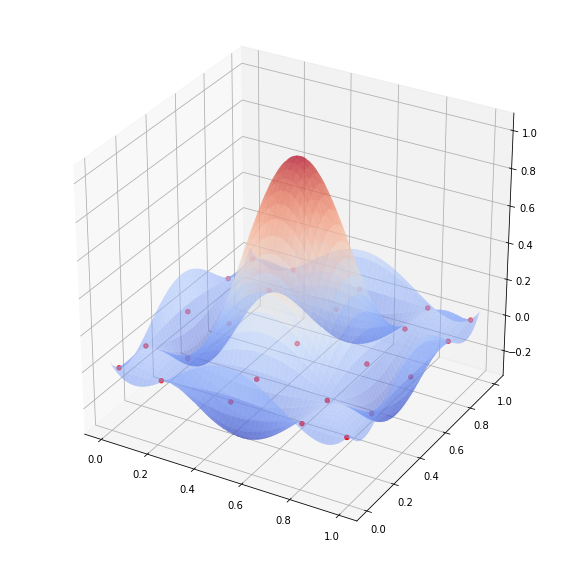

In [31]:
X = meshgrid(s, s)
Q = meshgrid(C, C)

fig = figure(figsize=[10,10])

ax = fig.gca(projection='3d')

surf2 = ax.plot_surface(X[0], X[1], V2s[2,2,:,:], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')

### 8 Assemble the matrices and the right hand side

Using `einsum`, assemble the arrays representing the matrices and then resize them to be two-dimensional. Careful on how the stiffness matrix is defined:

$$
K_{ij \, kl} = \int_{\Omega} \nabla v_{ij} \cdot \nabla v_{kl} = \sum_q \sum_r (v'_j(x_r)v_i(y_q) v'_l(x_r)v_k(y_q) +v_j(x_r)v'_i(y_q) v_l(x_r)v'_k(y_q) )w_r w_q
$$

Using summation convention, this is equivalent to:

```
(Vm[i][q]*Dm[j][r] Vm[k][q]*Dm[l][r] + Dm[i][q]*Vm[j][r] *Dm[k][q]Vm[l][r])W[r]*W[q]
```
or
```
(VDm[q][r][i][j] + DVm[q][r][i][j])W2[q,r]
```

In [32]:
M = einsum('ijqr, klqr, qr', V2m, V2m, W2m)
M = M.reshape((order**2, order**2))

K = einsum('ijqr, klqr, qr -> ijkl',DVm,DVm,W2m) + einsum('ijqr, klqr, qr -> ijkl',VDm,VDm,W2m)
K = K.reshape((order**2, order**2))

A = K + M

### 9 Using a known solution, construct a right hand side that would produce the given solution, and assemble it

Given a solution that satisfies the boundary conditions (for example:) 

$$
u(x,y) = \cos(\pi x)\cos(3\pi y)
$$
compute its laplacian, put a minus in front of it, and sum $u$ to it. The result is the forcing term $f$ that you have to use in order to obtain $u$ as a solution to the problem. Call it `my_function`, compute the right hand side by integrating with the basis functions and reshape it to be a vector of size `order^2`:

In [33]:
def my_function(x,y):
    t,l = sym.symbols('t l')
    funz = sym.cos(sym.pi*t)*sym.cos(3*sym.pi*l)
    derx = funz.diff(t,1)
    derxx = funz.diff(t,2)
    dery = funz.diff(l,1)
    deryy = funz.diff(l,2)
    
    #here I am computing the derivatives on the border to check if they're (almost) zero
    derx_lam = sym.lambdify((t,l), derx, 'numpy')
    dery_lam = sym.lambdify((t,l), dery, 'numpy')
    space = linspace(0,1,1000)
    arr = zeros((len(space)))
    assert_equal(derx_lam(0,space),arr)
    assert_almost_equal(derx_lam(1,space),arr,decimal=15)
    assert_almost_equal(dery_lam(space,0),arr)
    assert_almost_equal(dery_lam(space,1),arr,decimal=14)
  
    lapl_u = funz - (derxx + deryy)
    funct = sym.lambdify((t,l), lapl_u, 'numpy')
    
    F = zeros((len(x), len(y)))
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            F[i][j] = funct(xi,yj)
    return F

Fr = my_function(Qr,Qr)

bb = einsum('ijqr, qr, qr', V2r, Fr, W2r)
bb = bb.reshape((order**2))

In [34]:
def given_function(x,y):
    #this is u(x,y)
    u_funz = lambda t,l: np.cos(np.pi*t)*np.cos(3*np.pi*l)
    FF = zeros((len(x), len(y)))
    for i,xi in enumerate(x):
        for j,yj in enumerate(y):
            FF[i][j] = u_funz(xi,yj)
    return FF

### 10 Solve the linear system, and plot the solution

Use a direct solver to solve the linear system. Once you have the coefficients `u` as a vector, reshape it to a matrix, and use einsum to have its values on the `s` space.

True


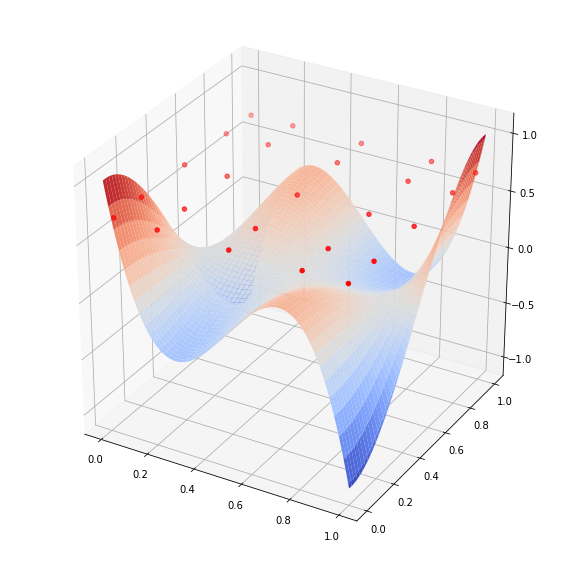

In [38]:
u = numpy.linalg.solve(A,bb)
print(np.allclose(np.dot(A, u), bb)) #checking the resolution of linear system
u = reshape(u, (order, order))
u_Vs = einsum('ijqr, ij -> qr', V2s, u)

line = linspace(0,1,257)
points = given_function(line,line)

X = meshgrid(s, s)
Q = meshgrid(C, C)

fig = figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X[0], X[1], u_Vs, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=1)
scatter = ax.scatter(Q[0], Q[1], u_Vs[0,8], c='r', marker='o') #u(Q[0])

### 11 Compute the L2 error of the solution

The L2 error is defined as 

$$
\| u - u_h \| := \sqrt{\int_\Omega (u(x,y) - u^{ij} V_{ij}(x,y))^2 dx\, dy } \sim \sum_q \sum_r (u(x_r, y_q) -V_{qrij} u^{ij})^2 W_{qr}
$$

use the quadrature formula and the matrix you constructed above to compute the approximate solutions at the quadrature points.

In [36]:
upoints = given_function(Qe,Qe)

u_Ve = einsum('ijqr, ij -> qr', V2e, u)

norma1 = einsum('qr, qr',(upoints - u_Ve)**2,W2e)
print(sqrt(norma1))

0.590251602046


### 12 Group together all of the above in a function

The function should take as input the `degree` of the one dimensional basis space, the degrees of the three quadrature formulas, a number of points where you want to produce the outputs.

Once you have the function, create a `log-log` plot of the L2 error with respect to the input degree

In [2]:
def final_function(degree ,m, r, e, resolution):

    #constructing chebyshev nodes
    a = 0
    b = 1
    C1 = zeros((degree))
    C1 = [ 0.5*(a+b) + 0.5*(b-a)*np.cos((2*k-1)*np.pi/(2*degree)) for k in range (1, degree + 1) ]

    #constructing 1d  basis
    def lagrange_basis1(xi, i):
        def funct(x):
            assert i<len(xi) and i>=0,  'Out of range: 0 t< i < len(xi)'
            p = 1
            for j,xj in enumerate(xi):
                if (j!=i):
                    p *= (x-xj)/(xi[i]-xj)
            return p
        return funct

    basis_1d = []
    for k in range(0,degree):
        basis_1d.append(lagrange_basis1(C1,k))
      
    #creating "plot space" s1 and filling matrix Vs1 where to plot the functions
    s1 = linspace(0,1,resolution)
    
    Vs1 = zeros((resolution, degree))
    for i in range(0, degree):
        Vs1[:,i] = basis_1d[i](s1)
    
    # constructing three one-dimensional quadrature formulas
    Qm1, Wm1 = leg.leggauss(m)
    Qm1 = (Qm1 + 1)/2
    Qr1, Wr1 = leg.leggauss(r)
    Qr1 = (Qr1 + 1)/2
    Qe1, We1 = leg.leggauss(e)
    Qe1 = (Qe1 + 1)/2

    # computing basis derivatives
    t = sym.var('t')
    
    basis_1d_sym = [basis_1d[i](t) for i in range(0,len(basis_1d))]
    basis_1d_sym_prime = [basis_1d_sym[i].diff(t,1) for i in range(0,len(basis_1d)) ]
    basis_1d_prime = [ sym.lambdify(t, basis_1d_sym_prime[i], 'numpy')  for i in range(0,len(basis_1d)) ]
    
    # evaluating 1d basis functions and derivatives at quadrature points
    Vm1 = zeros((m, degree))
    Dm1 = zeros((m, degree))
    Vr1 = zeros((r, degree))
    Dr1 = zeros((r, degree))
    Ve1 = zeros((e, degree))
    De1 = zeros((e, degree))

    for i in range(len(basis_1d)):
        Vm1[:,i] = basis_1d[i](Qm1)
        Vr1[:,i] = basis_1d[i](Qr1)
        Ve1[:,i] = basis_1d[i](Qe1)
        Dm1[:,i] = basis_1d_prime[i](Qm1)
        Dr1[:,i] = basis_1d_prime[i](Qr1)
        De1[:,i] = basis_1d_prime[i](Qe1)
    
    
    # computing 2d weights and 2d basis and mixed things
    W2m1 = einsum('q,r -> qr',Wm1, Wm1)
    W2r1 = einsum('q,r -> qr',Wr1, Wr1)
    W2e1 = einsum('q,r -> qr',We1, We1)
    
    V2m1 = einsum('iq, jr -> qrij', Vm1, Vm1)
    V2r1 = einsum('iq, jr -> qrij', Vr1, Vr1)
    V2e1 = einsum('iq, jr -> qrij', Ve1, Ve1)
    VDm1 = einsum('iq, jr -> qrij', Vm1, Dm1)
    DVm1 = einsum('iq, jr -> qrij', Dm1, Vm1)
    V2s1 = einsum('iq, jr -> qrij', Vs1, Vs1)
    
    # computing mass and stiffness matrices, than gruoped in A matrix
    M1 = einsum('ijqr, klqr, qr', V2m1, V2m1, W2m1)
    M1 = M1.reshape((degree**2, degree**2))
    K1 = einsum('ijqr, klqr, qr -> ijkl',DVm1,DVm1,W2m1) + einsum('ijqr, klqr, qr -> ijkl',VDm1,VDm1,W2m1) 
    K1 = K1.reshape((degree**2, degree**2))
    
    A1 = K1 + M1

    # computing right hand side.
    def my_function1(x,y):
        """
        my_function returns left-hand side computed on given points;
        furthermore it checks the value of the gradient of the given 
        function on borders of [0,1]x[0,1]
        """
        t,l = sym.symbols('t l')
        u_fun = sym.cos(sym.pi*t)*sym.cos(3*sym.pi*l)
        derx = u_fun.diff(t,1) 
        derxx = u_fun.diff(t,2)
        dery = u_fun.diff(l,1)
        deryy = u_fun.diff(l,2)
        
        #checking gradient on the borders
        derx_lam = sym.lambdify((t,l), derx, 'numpy')
        dery_lam = sym.lambdify((t,l), dery, 'numpy')
        space = linspace(0,1,1000)
        zeros_arr = zeros((len(space)))
        assert_equal(derx_lam(0,space),zeros_arr)
        assert_almost_equal(derx_lam(1,space),zeros_arr,decimal=15)
        assert_equal(dery_lam(space,0),zeros_arr)
        assert_almost_equal(dery_lam(space,1),zeros_arr,decimal=14)
        
        #computing (function - function_laplacian)
        lapl_u_sym = u_fun - (derxx + deryy)
        lapl_u = sym.lambdify((t,l), lapl_u_sym, 'numpy')
        
        F = zeros((len(x), len(y)))
        for i,xi in enumerate(x):
            for j,yj in enumerate(y):
                F[i][j] = lapl_u(xi,yj)
        return F

    Fr1 = my_function1(Qr1,Qr1)
    bb1 = einsum('ijqr, qr, qr', V2r1, Fr1, W2r1)
    bb1 = bb1.reshape((degree**2))
    
    # solving system in direct way
    u1 = np.linalg.solve(A1,bb1)
    u1 = reshape(u1, (degree, degree))
    
    # computing L2 error
    def given_function1(x,y):
        u_funz = lambda t,l: np.cos(np.pi*t)*np.cos(3*np.pi*l)
        FF = zeros((len(x), len(y)))
        for i,xi in enumerate(x):
            for j,yj in enumerate(y):
                FF[i][j] = u_funz(xi,yj)
        return FF
        
    upoints1 = given_function1(Qe1,Qe1)
    u_Ve1 = einsum(' ijqr, ij-> qr ',V2e1,u1)
    l2error = einsum('qr, qr',(upoints1 - u_Ve1)**2,W2e1)
    #print(sqrt(l2error))
    
    # plots on Vs1(2D) and V2s1(3D) basis
    """_ =  plot(s1, Vs1)
    
    u_Vs1 = einsum('ijqr, ij -> qr', V2s1, u1)
    
    X = meshgrid(s1, s1)
    Q = meshgrid(C1, C1)
    fig = figure(figsize=[6,10])
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    surf = ax.plot_surface(X[0], X[1], V2s1[2,2,:,:], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
    scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')
    
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    surf = ax.plot_surface(X[0], X[1], u_Vs1, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=1)
    scatter = ax.scatter(Q[0], Q[1], u_Vs1[0,1], c='r', marker='o')
    plt.show()
    """
    return sqrt(l2error)

final_function(5, 70, 80, 90, 275)

0.59025160204572524

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


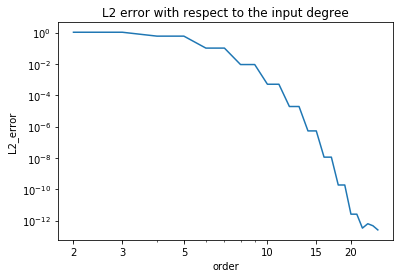

In [20]:
#PLOTTING L2 NORM AS A FUNCTION OF THE INPUT DEGREE

max_order = 25
norm_list = []
for k in range(2,max_order+1):
    norm_list.append(final_function(k, 70, 80, 90, 257))
    
plotpoints = [i for i in range(2,len(norm_list)+2)]
#print(plotpoints)

fig1, ax1 = plt.subplots()
ax1.plot(plotpoints,norm_list)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('order')
ax1.set_ylabel('L2_error')
ax1.set_title('L2 error with respect to the input degree')
ax1.set_xticks([2, 3, 5, 10, 15, 20])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

### 13 [OPTIONAL] Augment the function above

Make it take an optional argument that switches from a direct to an iterative solver (use CG, with a simple preconditioner of your choice).

Make a plot of cost it takes to run with iterative VS direct solvers. Is there a cross over point? For what degree?

Here you can find "augmented_final_function", which is the same function as above, but with the possibility to choose the use of the   with iterative method of conjugated gradient.<br \>
To implement this method, I had to search a preconditioner P such that the condition number of P\*A was smaller as possible).<br \>
Usually a good preconditioner is the inverse of a matrix, so I decided to use it. I computed P as the inverse of the matrix A: Precond_A = np.inv(A). Indeed, comparing the condition numbers of A and A\*Precond_A I saw that the las one was way smaller than the first, becaming better and better as the number of the basis was increased.<br \>
Below the "augmented_final_function" you can find the graph of the computing times obtained from the command "%timeit", using iterative and direct methods, as a function of the chosen degree (that is the number of basis_1d created).<br \>

Actually I can't see a good difference in computing times using the conjugate gradient method...If seems like the direct method definitely exceeds the conjugated method above the degree 12.<br \>
I do not think there are computational errors, because the resolution of the system, using both methods, give the same final L2 error.<br \><br \>


I am sorry if my code is too "strict"...but I manage to handle better my work writing this way :)

In [48]:
#plots here are commented!

def augmented_final_function(degree ,m, r, e, resolution, iterative = False):

    #constructing chebyshev nodes
    a = 0
    b = 1
    C1 = zeros((degree))
    C1 = [ 0.5*(a+b) + 0.5*(b-a)*np.cos((2*k-1)*np.pi/(2*degree)) for k in range (1, degree + 1) ]

    #constructing 1d  basis
    def lagrange_basis1(xi, i):
        def funct(x):
            assert i<len(xi) and i>=0,  'Out of range: 0 t< i < len(xi)'
            p = 1
            for j,xj in enumerate(xi):
                if (j!=i):
                    p *= (x-xj)/(xi[i]-xj)
            return p
        return funct

    basis_1d = []
    for k in range(0,degree):
        basis_1d.append(lagrange_basis1(C1,k))
      
    #creating "plot space" s1 and filling matrix Vs1 where to plot the functions
    s1 = linspace(0,1,resolution)
    
    Vs1 = zeros((resolution, degree))
    for i in range(0, degree):
        Vs1[:,i] = basis_1d[i](s1)
    
    # constructing three one-dimensional quadrature formulas
    Qm1, Wm1 = leg.leggauss(m)
    Qm1 = (Qm1 + 1)/2
    Qr1, Wr1 = leg.leggauss(r)
    Qr1 = (Qr1 + 1)/2
    Qe1, We1 = leg.leggauss(e)
    Qe1 = (Qe1 + 1)/2

    # computing basis derivatives
    t = sym.var('t')
    
    basis_1d_sym = [basis_1d[i](t) for i in range(0,len(basis_1d))]
    basis_1d_sym_prime = [basis_1d_sym[i].diff(t,1) for i in range(0,len(basis_1d)) ]
    basis_1d_prime = [ sym.lambdify(t, basis_1d_sym_prime[i], 'numpy')  for i in range(0,len(basis_1d)) ]
    
    # evaluating 1d basis functions and derivatives at quadrature points
    Vm1 = zeros((m, degree))
    Dm1 = zeros((m, degree))
    Vr1 = zeros((r, degree))
    Dr1 = zeros((r, degree))
    Ve1 = zeros((e, degree))
    De1 = zeros((e, degree))

    for i in range(len(basis_1d)):
        Vm1[:,i] = basis_1d[i](Qm1)
        Vr1[:,i] = basis_1d[i](Qr1)
        Ve1[:,i] = basis_1d[i](Qe1)
        Dm1[:,i] = basis_1d_prime[i](Qm1)
        Dr1[:,i] = basis_1d_prime[i](Qr1)
        De1[:,i] = basis_1d_prime[i](Qe1)
    
    
    # computing 2d weights and 2d basis and mixed things
    W2m1 = einsum('q,r -> qr',Wm1, Wm1)
    W2r1 = einsum('q,r -> qr',Wr1, Wr1)
    W2e1 = einsum('q,r -> qr',We1, We1)
    
    V2m1 = einsum('iq, jr -> qrij', Vm1, Vm1)
    V2r1 = einsum('iq, jr -> qrij', Vr1, Vr1)
    V2e1 = einsum('iq, jr -> qrij', Ve1, Ve1)
    VDm1 = einsum('iq, jr -> qrij', Vm1, Dm1)
    DVm1 = einsum('iq, jr -> qrij', Dm1, Vm1)
    V2s1 = einsum('iq, jr -> qrij', Vs1, Vs1)
    
    # computing mass and stiffness matrices, than gruoped in A matrix
    M1 = einsum('ijqr, klqr, qr', V2m1, V2m1, W2m1)
    M1 = M1.reshape((degree**2, degree**2))
    K1 = einsum('ijqr, klqr, qr -> ijkl',DVm1,DVm1,W2m1) + einsum('ijqr, klqr, qr -> ijkl',VDm1,VDm1,W2m1) 
    K1 = K1.reshape((degree**2, degree**2))
    
    A1 = K1 + M1
    #print(cond(A1))
    # computing right hand side.
    def my_function1(x,y):
        """
        this my function returns left-hand side computed on given points
        furthermore it checks the value of the gradient of the given 
        function on borders of [0,1]x[0,1]
        """
        t,l = sym.symbols('t l')
        u_fun = sym.cos(sym.pi*t)*sym.cos(3*sym.pi*l)
        derx = u_fun.diff(t,1) 
        derxx = u_fun.diff(t,2)
        dery = u_fun.diff(l,1)
        deryy = u_fun.diff(l,2)
        
        #checking gradient on the borders
        derx_lam = sym.lambdify((t,l), derx, 'numpy')
        dery_lam = sym.lambdify((t,l), dery, 'numpy')
        space = linspace(0,1,1000)
        zeros_arr = zeros((len(space)))
        assert_equal(derx_lam(0,space),zeros_arr)
        assert_almost_equal(derx_lam(1,space),zeros_arr,decimal=15)
        assert_equal(dery_lam(space,0),zeros_arr)
        assert_almost_equal(dery_lam(space,1),zeros_arr,decimal=14)
        
        #computing (function - function_laplacian)
        lapl_u_sym = u_fun - (derxx + deryy)
        lapl_u = sym.lambdify((t,l), lapl_u_sym, 'numpy')
        
        F = zeros((len(x), len(y)))
        for i,xi in enumerate(x):
            for j,yj in enumerate(y):
                F[i][j] = lapl_u(xi,yj)
        return F

    Fr1 = my_function1(Qr1,Qr1)
    bb1 = einsum('ijqr, qr, qr', V2r1, Fr1, W2r1)
    bb1 = bb1.reshape((degree**2))
    
    # solving system
    if (iterative == True):
        #solving system using iterative solver:
        #preconditioned gradient using as preconditioner the 
        #inverse of the matrix A1
        Precond_A = np.linalg.inv(A1)
        result = cg(A1, bb1, x0=None, tol=1e-05, maxiter=None, M=Precond_A)
        #print(cond(A1)) #bad
        #print(cond((Precond_A*A1))) #good!!
        u1 = result[0]
        u1 = reshape(u1, (degree, degree))
    else:
        #solving system in direct way
        u1 = np.linalg.solve(A1,bb1)
        u1 = reshape(u1, (degree, degree))
    
    # computing L2 error
    def given_function1(x,y):
        u_funz = lambda t,l: np.cos(np.pi*t)*np.cos(3*np.pi*l)
        FF = zeros((len(x), len(y)))
        for i,xi in enumerate(x):
            for j,yj in enumerate(y):
                FF[i][j] = u_funz(xi,yj)
        return FF
        
    upoints1 = given_function1(Qe1,Qe1)
    u_Ve1 = einsum(' ijqr, ij-> qr ',V2e1,u1)
    l2error = einsum('qr, qr',(upoints1 - u_Ve1)**2,W2e1)
    #print(sqrt(l2error))
    
    """
    # 3D plots on V2s1 basis
    u_Vs1 = einsum('ijqr, ij -> qr', V2s1, u1)
    X = meshgrid(s1, s1)
    Q = meshgrid(C1, C1)
    fig = figure(figsize=[6,10])
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    surf = ax.plot_surface(X[0], X[1], V2s1[2,2,:,:], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
    scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')
    
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    surf = ax.plot_surface(X[0], X[1], u_Vs1, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=1)
    scatter = ax.scatter(Q[0], Q[1], u_Vs1[0,1], c='r', marker='o')
    plt.show()
    """
    return sqrt(l2error)

augmented_final_function(5, 70, 80, 90, 275, iterative = True)

0.590251602046


0.59025160204572524

Timings obtained from the runs for the direct solver as a function of the selected degree.

2 131 ms ± 533 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)<br\>
3 144 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)<br\>
4 167 ms ± 978 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)<br\>
5 252 ms ± 8.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
6 316 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
7 404 ms ± 8.89 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
8 523 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
9 721 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
10 930 ms ± 42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
11 1.57 s ± 73.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
12 2.09 s ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
13 2.76 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
14 3.32 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
15 4.34 s ± 80.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
16 5.32 s ± 95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
17 6.75 s ± 77.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
18 7.77 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
19 9.70 s ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
20 11.1 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
22 18.6 s ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
27 37.3 s ± 88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
32 1min 3s ± 5.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
37 1min 57s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>

Timings obtained from the runs for the iterative solver as a function of the selected degree.

2 172 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)<br\>
3 180 ms ± 990 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)<br\>
4 206 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
5 243 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
6 312 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
7 392 ms ± 2.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
8 507 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
9 685 ms ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
10 904 ms ± 39.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
11 1.48 s ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
12 2.22 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
13 2.66 s ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
14 3.25 s ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
15 4.12 s ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
16 5.32 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
17 6.49 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
18 9.18 s ± 702 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
19 11.6 s ± 83.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>
20 13.5 s ± 82.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)<br\>

In [50]:
#for k in range(2,21):
#    print(k)
#    %timeit (augmented_final_function(k,70,80,90,257))
    
for i in range(2,21):
    print(i)
    %timeit (augmented_final_function(k,70,80,90,257))
    %timeit (augmented_final_function(i,70,80,90,257,iterative = True))

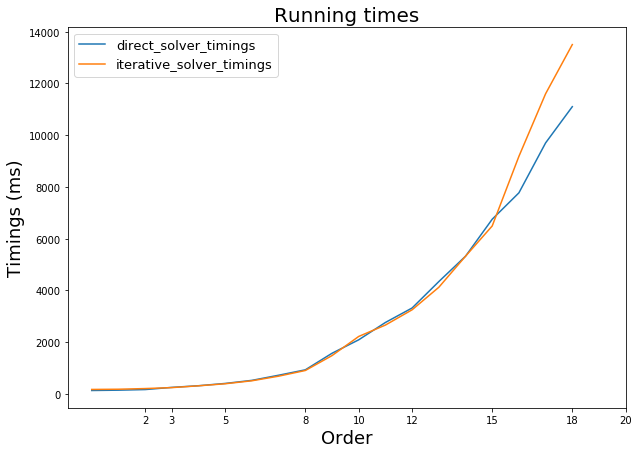

In [41]:
direct_solver_timings = [131,144,167,252,316,404,523,721,930,   1570,2090,2760,3320,4340,5320,6750,7770,9700,11100]#,18600,37300]
iterative_solver_timi = [172,180,206,243,312,392,507,685,904,  1480,2220,2660,3250,4120,5320,6490,9180,11600,13500]   #iterative_solver_timi = [195,181,244,248,375,409,647,718,1190,  1540,2570,2780,4080,4330,6760,6870,9570,9680,13600]

num_timings = [i for i in range(0, len(direct_solver_timings))]
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(num_timings,direct_solver_timings, label = 'direct_solver_timings')
ax1.plot(num_timings,iterative_solver_timi, label = 'iterative_solver_timings')

ax1.set_xlabel('Order', fontsize =18)
ax1.set_ylabel('Timings (ms)', fontsize =18)
ax1.set_title('Running times', fontsize =20)
ax1.set_xticks([2, 3, 5, 8, 10, 12, 15, 18,20])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

handles, labels = ax1.get_legend_handles_labels()
_ = ax1.legend(handles, labels, fontsize = 13)

### 14 [OPTIONAL] Matrix free

Using the iterative solver, implement a matrix-free approach where the computation of the matrices is substituted with a  function that returns the *matrix-vector* product. In doing so, you must take care of rewriting the assemble of the matrix as a sum of many *matrix-matrix* products exploiting all the possible tensor products. 

Compare and comment the compuational cost of 100 matrix-vector product when the matrix is assembled and when it is computed on-the-fly as a function of the degree of the finite element. Is there a cross-over point? Is matrix free always convenient?

To see an explanation of how matrix free works, take a look at this page: 

https://www.dealii.org/8.5.0/doxygen/deal.II/step_37.html